## 프로젝트 설명

본 프로젝트는 캐글 대회의 집값 예측 주제를 가지고, EDA, 모델 선정 및 하이퍼 파라미터를 통해 캐글 대회에서 11만점 이하의 점수를 얻는 것이 목표다.

## 패키지 임포트

In [ ]:
! pip install plotly

In [42]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import plotly.graph_objects as go

import missingno as msno


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## 데이터 콜렉션

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
train['price'] = np.log1p(train['price'])

In [43]:
train.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00     7.074117  8.639588     1.0           0   
1  20150225         2       1.00     6.647688  9.210440     1.0           0   
2  20150218         3       2.00     7.427144  8.997271     1.0           0   
3  20140627         3       2.25     7.447751  8.827615     2.0           0   
4  20150115         3       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...      lat     long  sqft_living15  sqft_lot15  \
0     0          3      7  ...  47.5112 -122.257           1340        5650   
1     0          3      6  ...  47.7379 -122.233           2720        8062   
2     0          3      8  ...  47.6168 -122.045           1800        7503   
3     0          3      7  ...  47.3097 -122.327           2238        6819   
4     0          3      7  ...  47.4095 -122.315           1650        9711   

   total_rooms  grade_condition  sqft_total  sqft_total_size  sqft_total15  \
0         4.00               21   15.713705        22.787821          6990   
1         3.00               18   15.858129        22.505817         10782   
2         5.00               24   16.424415        23.851559          9303   
3         5.25               21   16.275366        23.723117          9057   
4         4.50               21   16.148085        23.115052         11361   

   is_renovated  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 25 columns]

## 결측치 조사

<AxesSubplot:>

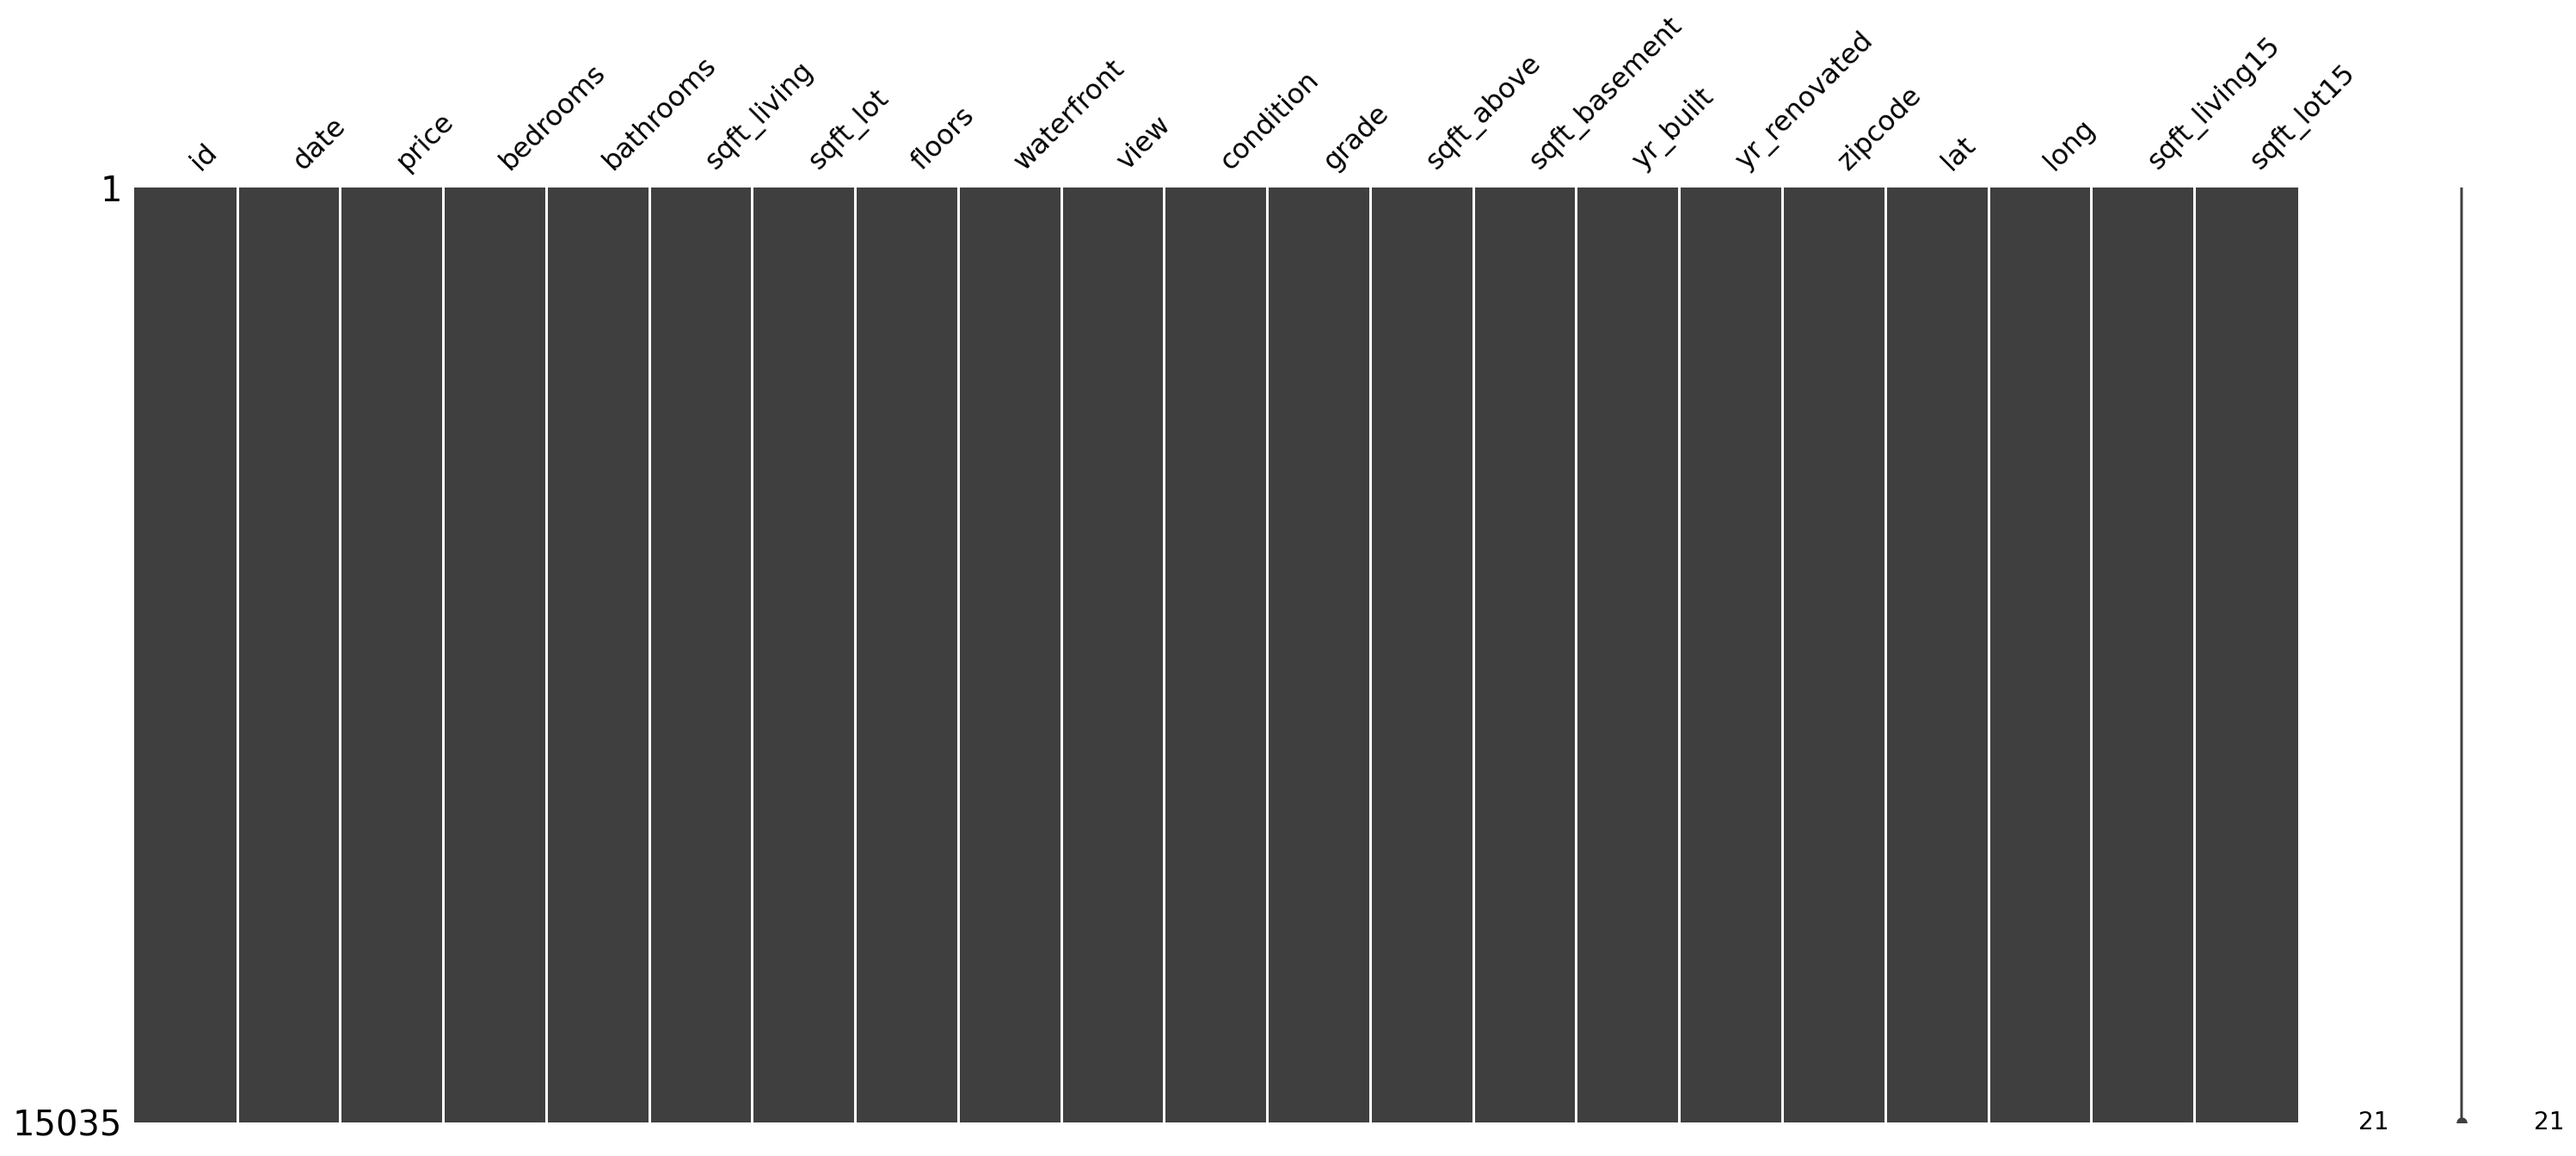

In [6]:
msno.matrix(train)

In [44]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
total_rooms : 0
grade_condition : 0
sqft_total : 0
sqft_total_size : 0
sqft_total15 : 0
is_renovated : 0


## Target과 높은 상관관계를 보이는 feature 확인

In [46]:
'''
https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook?scriptVersionId=11425534
'''
plt.figure(figsize=(20, 10))
corr = train.corr(method = 'spearman')
corr_10 = corr.nlargest(10, 'price', keep = 'first').index
cm = np.corrcoef(train[corr_10].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, annot = True, square=True, yticklabels = corr_10.values, xticklabels = corr_10.values)
plt.show()

KeyError: 'price'

<Figure size 1440x720 with 0 Axes>

## 높은 상관관계가 보이는 feature 순서대로 데이터 시각화 및 엔지니어링

### Grade

7     6228
8     4207
9     1855
6     1406
10     781
11     288
5      174
12      61
4       23
13       9
3        2
1        1
Name: grade, dtype: int64

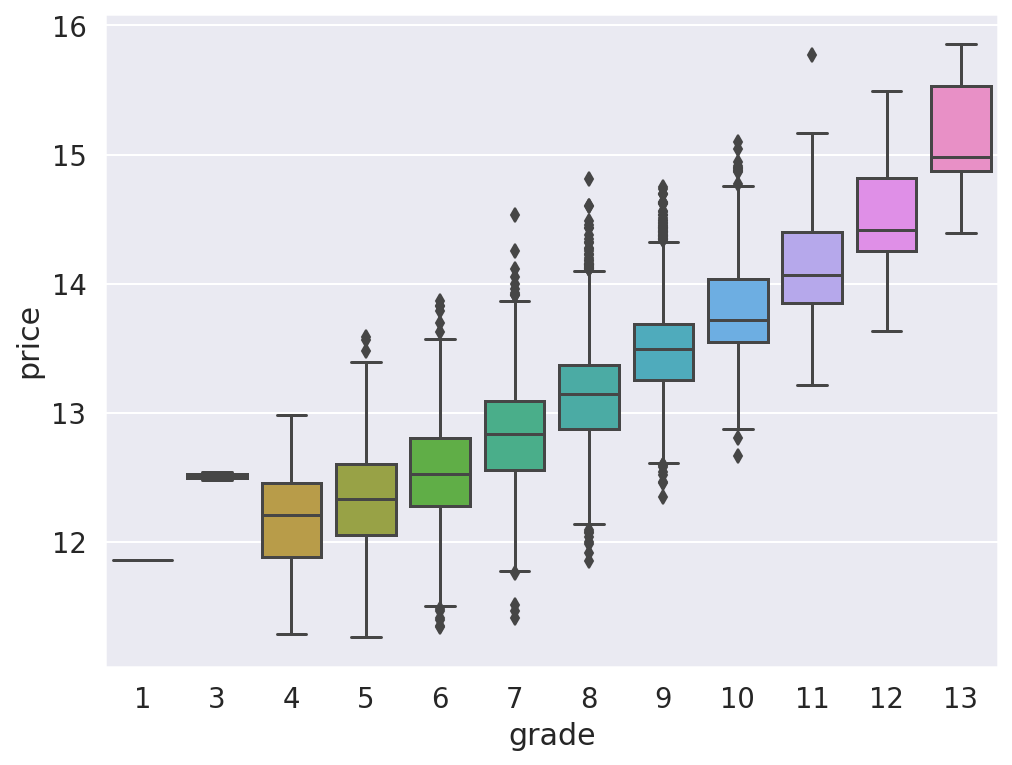

In [9]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=train)
train['grade'].value_counts()

In [10]:
train = train[train['grade'] >= 4]

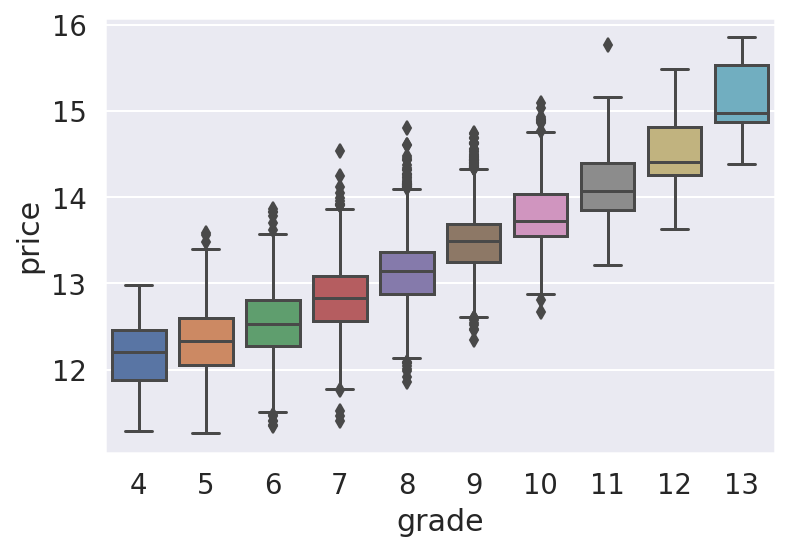

In [11]:
fig = sns.boxplot(x='grade', y="price", data=train)

In [12]:
q1 = train.groupby('grade').quantile(0.25)['price']
q3 = train.groupby('grade').quantile(0.75)['price']
iqr = q3 - q1

grade_unique_sorted = sorted(train['grade'].unique())

results = pd.DataFrame()
for i in range(len(grade_unique_sorted)):
    temp_df = train[( train['grade'] == grade_unique_sorted[i] ) & ( train['price'] >= (q1-1.5*iqr).iloc[i] ) & ( train['price'] <= (q3+1.5*iqr).iloc[i] )]
    results = pd.concat([results, temp_df])
results.sort_values(by='id' ,ascending = True, inplace = True)
train = results

In [47]:
fig = sns.boxplot(x='grade', y="price", data=train)

ValueError: Could not interpret input 'price'

### Sqft_living

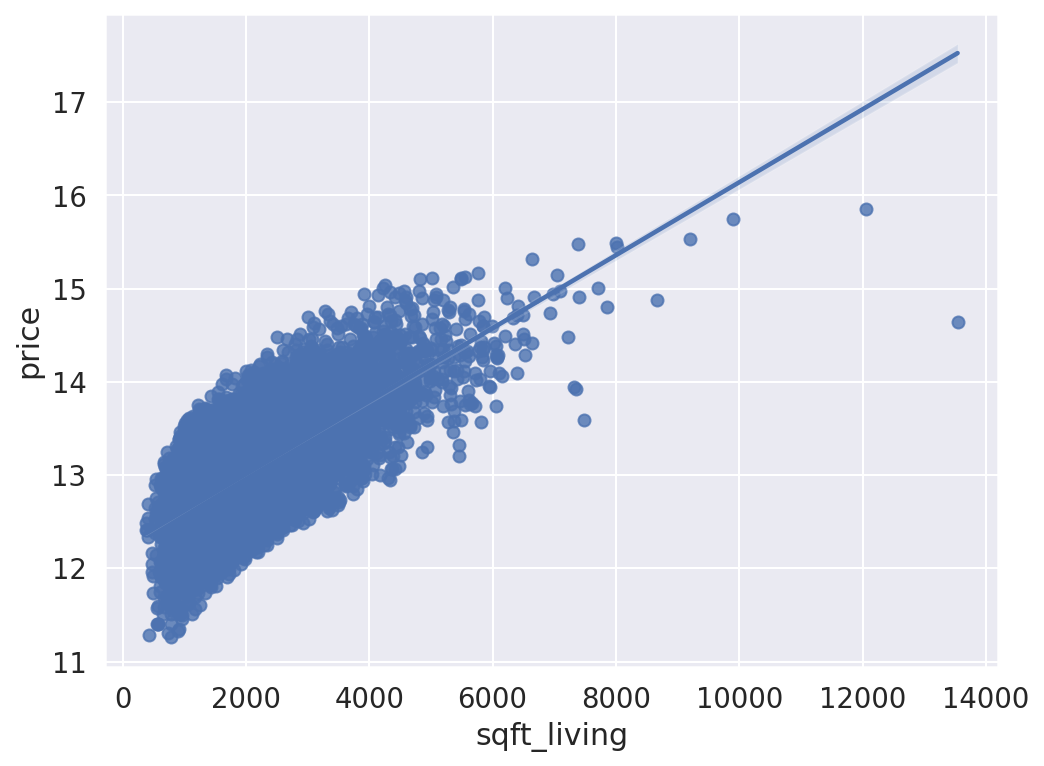

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=train)

In [17]:
train = train[~( train['sqft_living'] > 13000 )]

### Sqft_living15

KeyError: 'price'

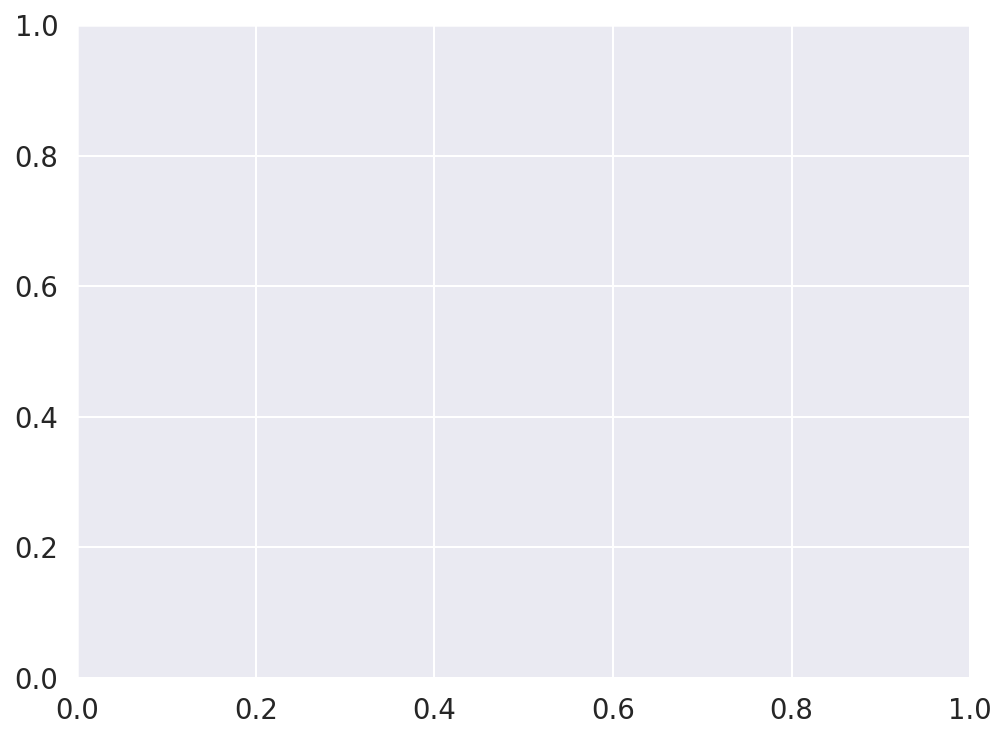

In [49]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=train)

### Sqft_above

KeyError: 'price'

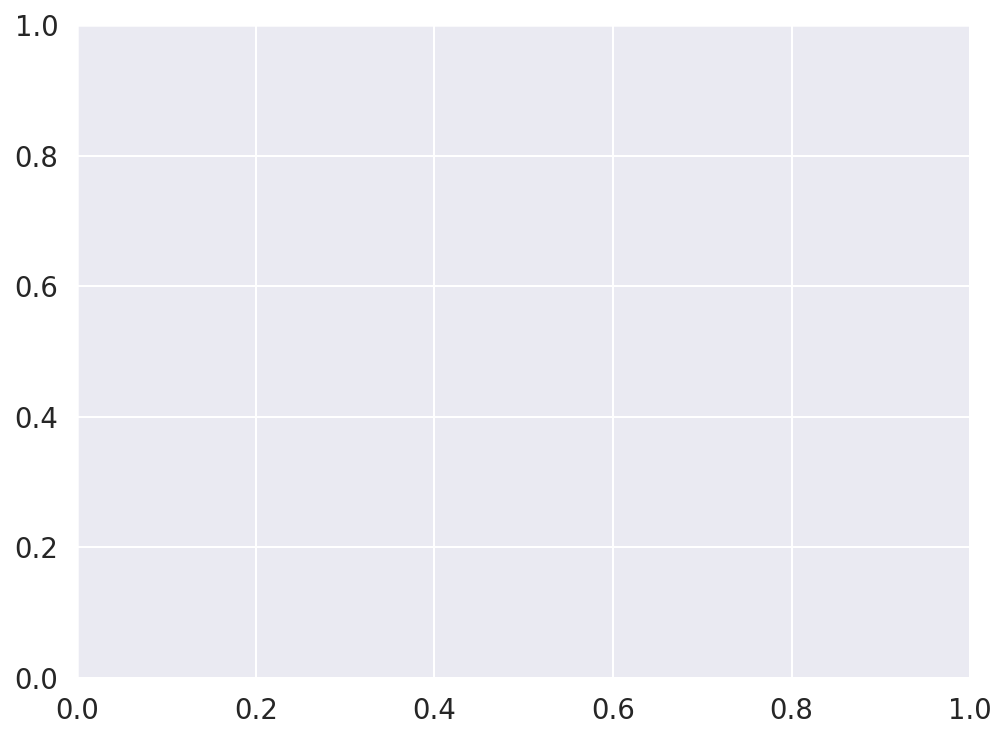

In [50]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=train)

### Bathrooms

ValueError: Could not interpret input 'price'

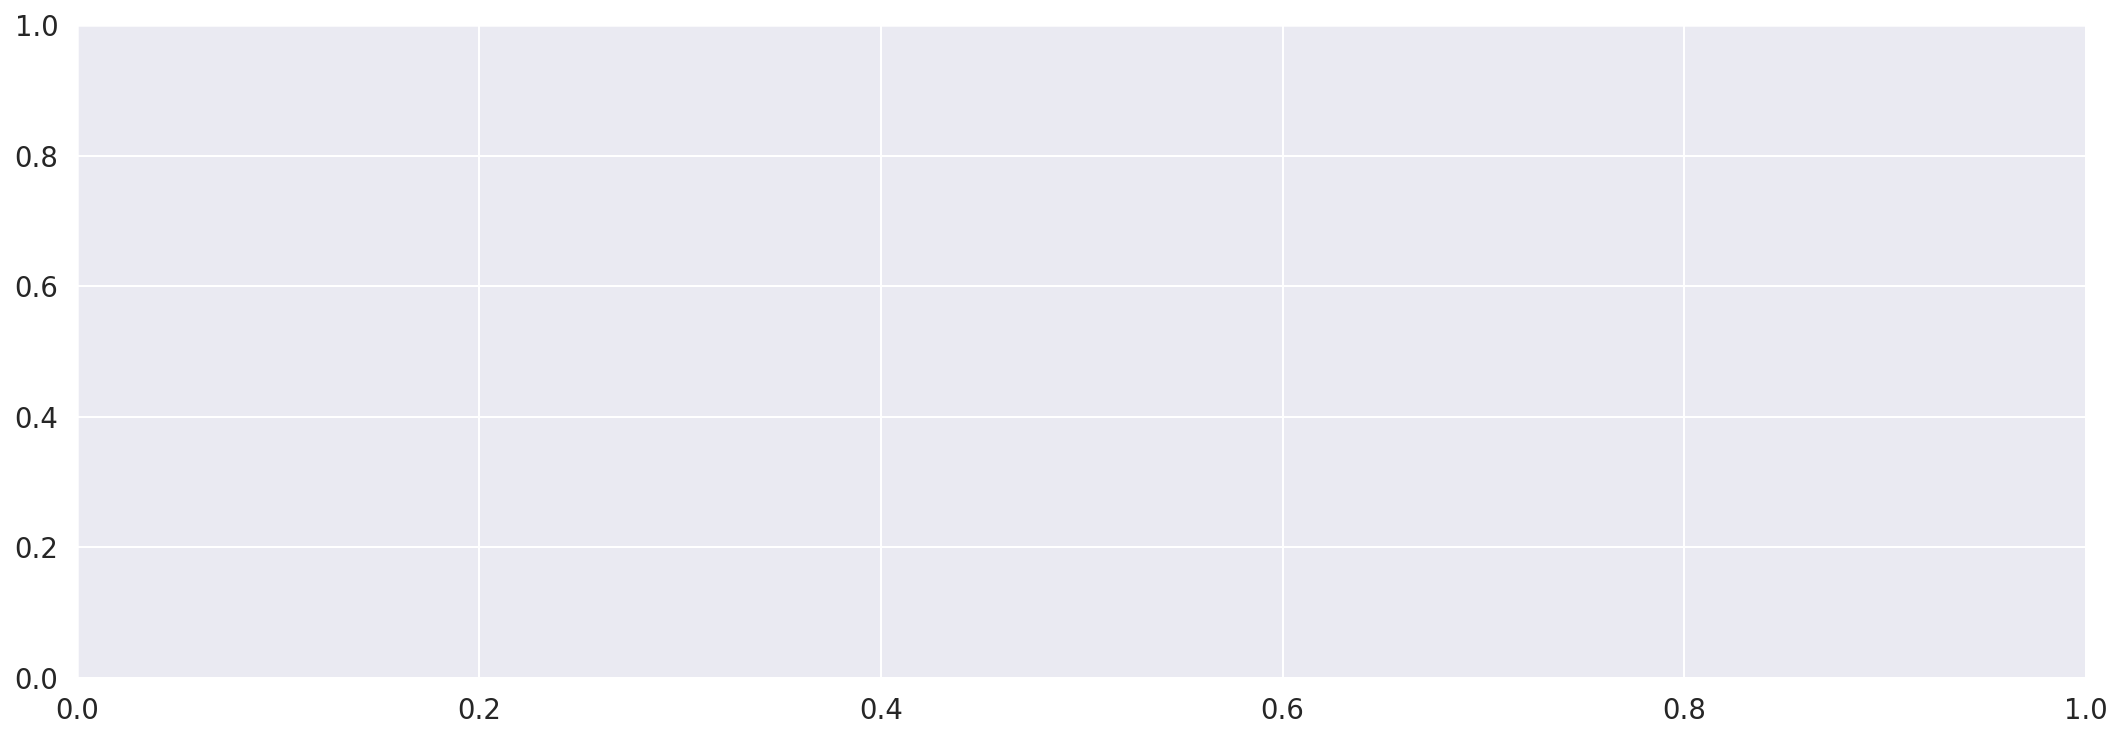

In [51]:
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=train)

In [ ]:
train = train[~( train['bathrooms'] > 6.0 )]

### Bedrooms

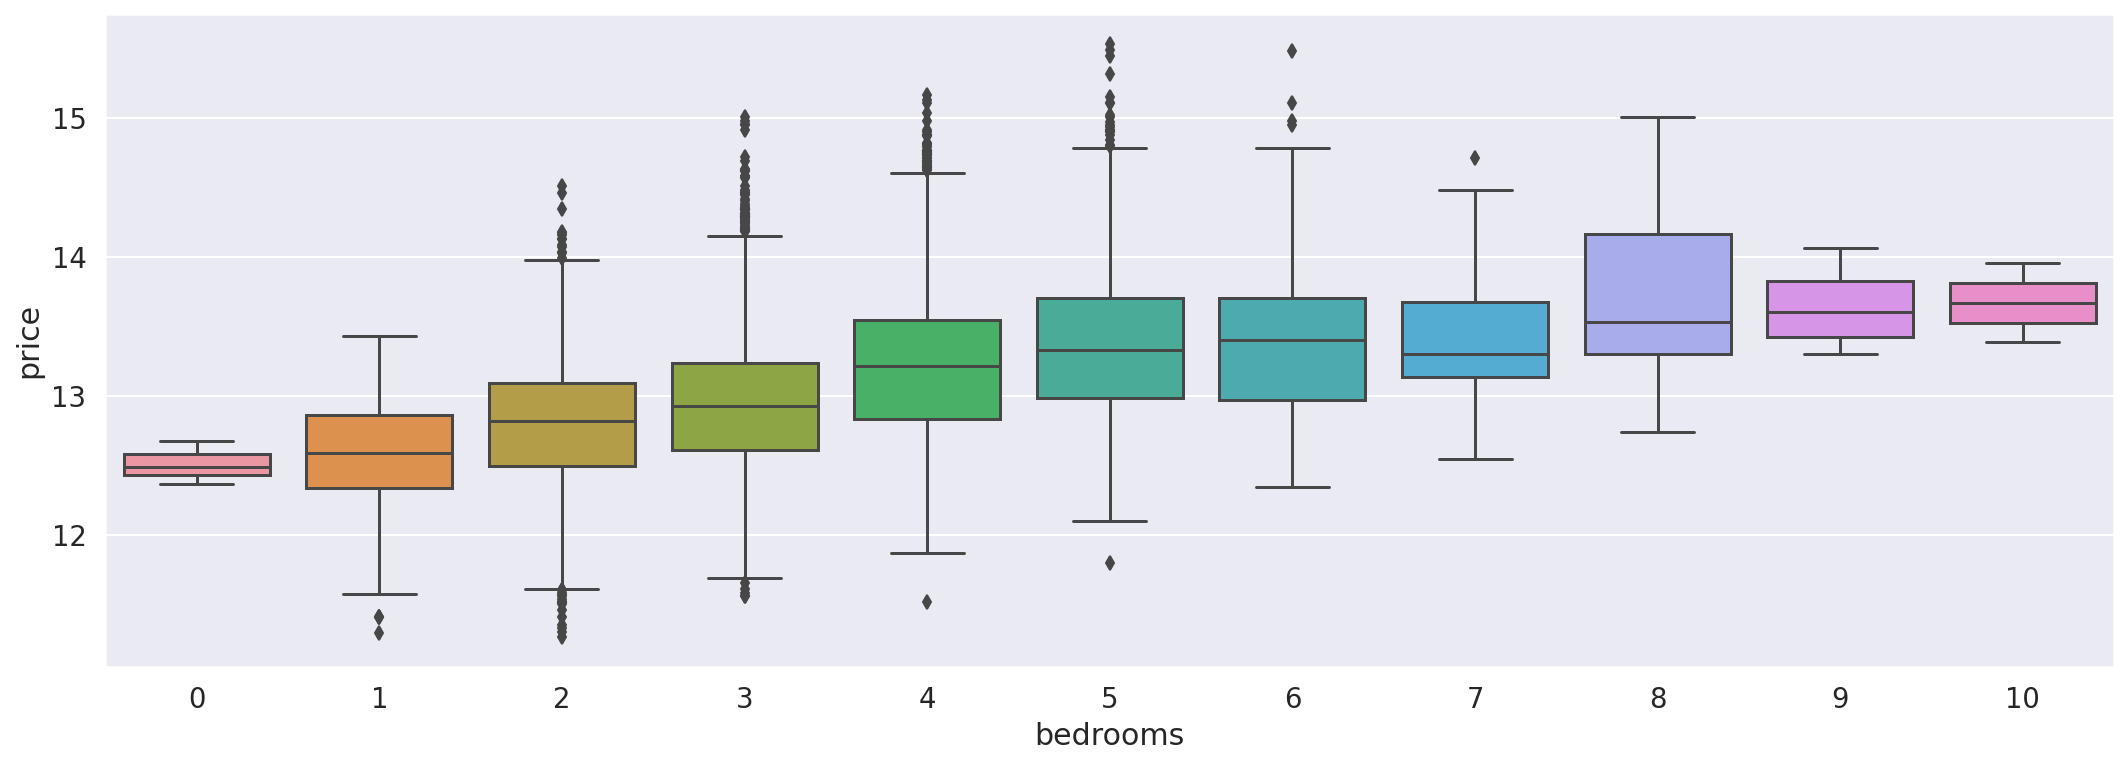

In [22]:
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=train)

## 그 외 feature들 분포 조사

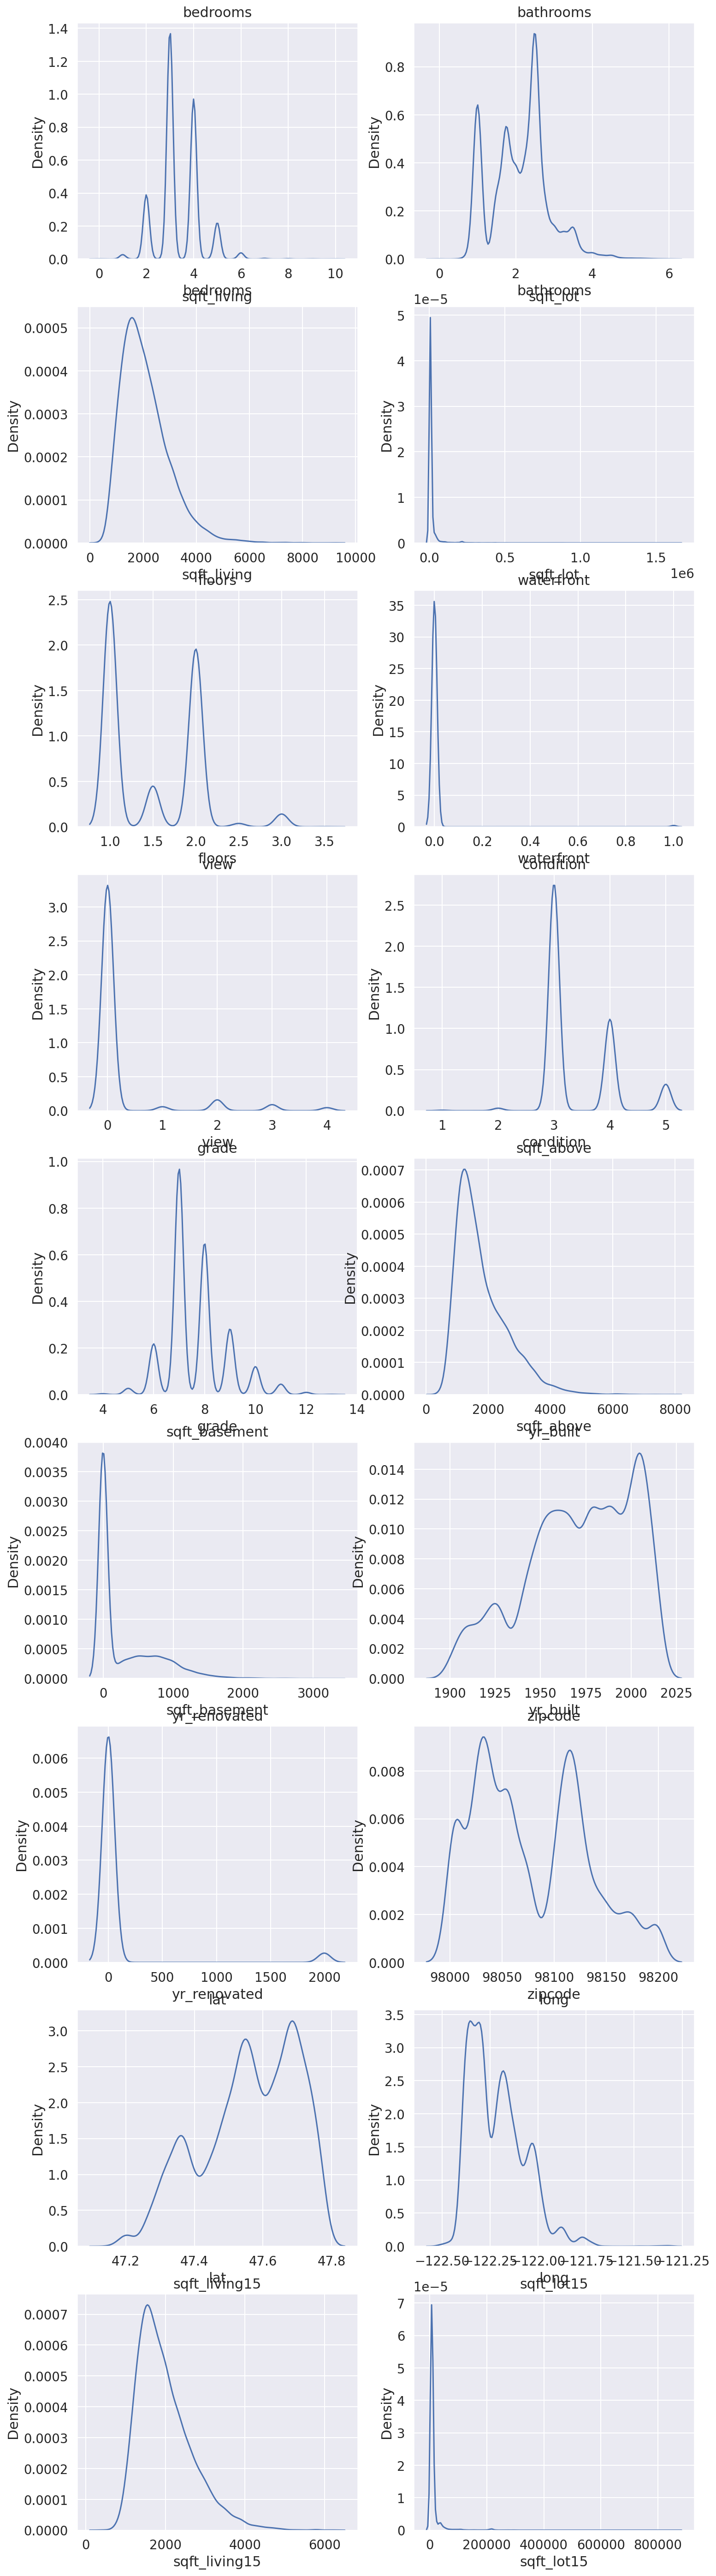

In [23]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns[2:]
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### log 정규화

In [24]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

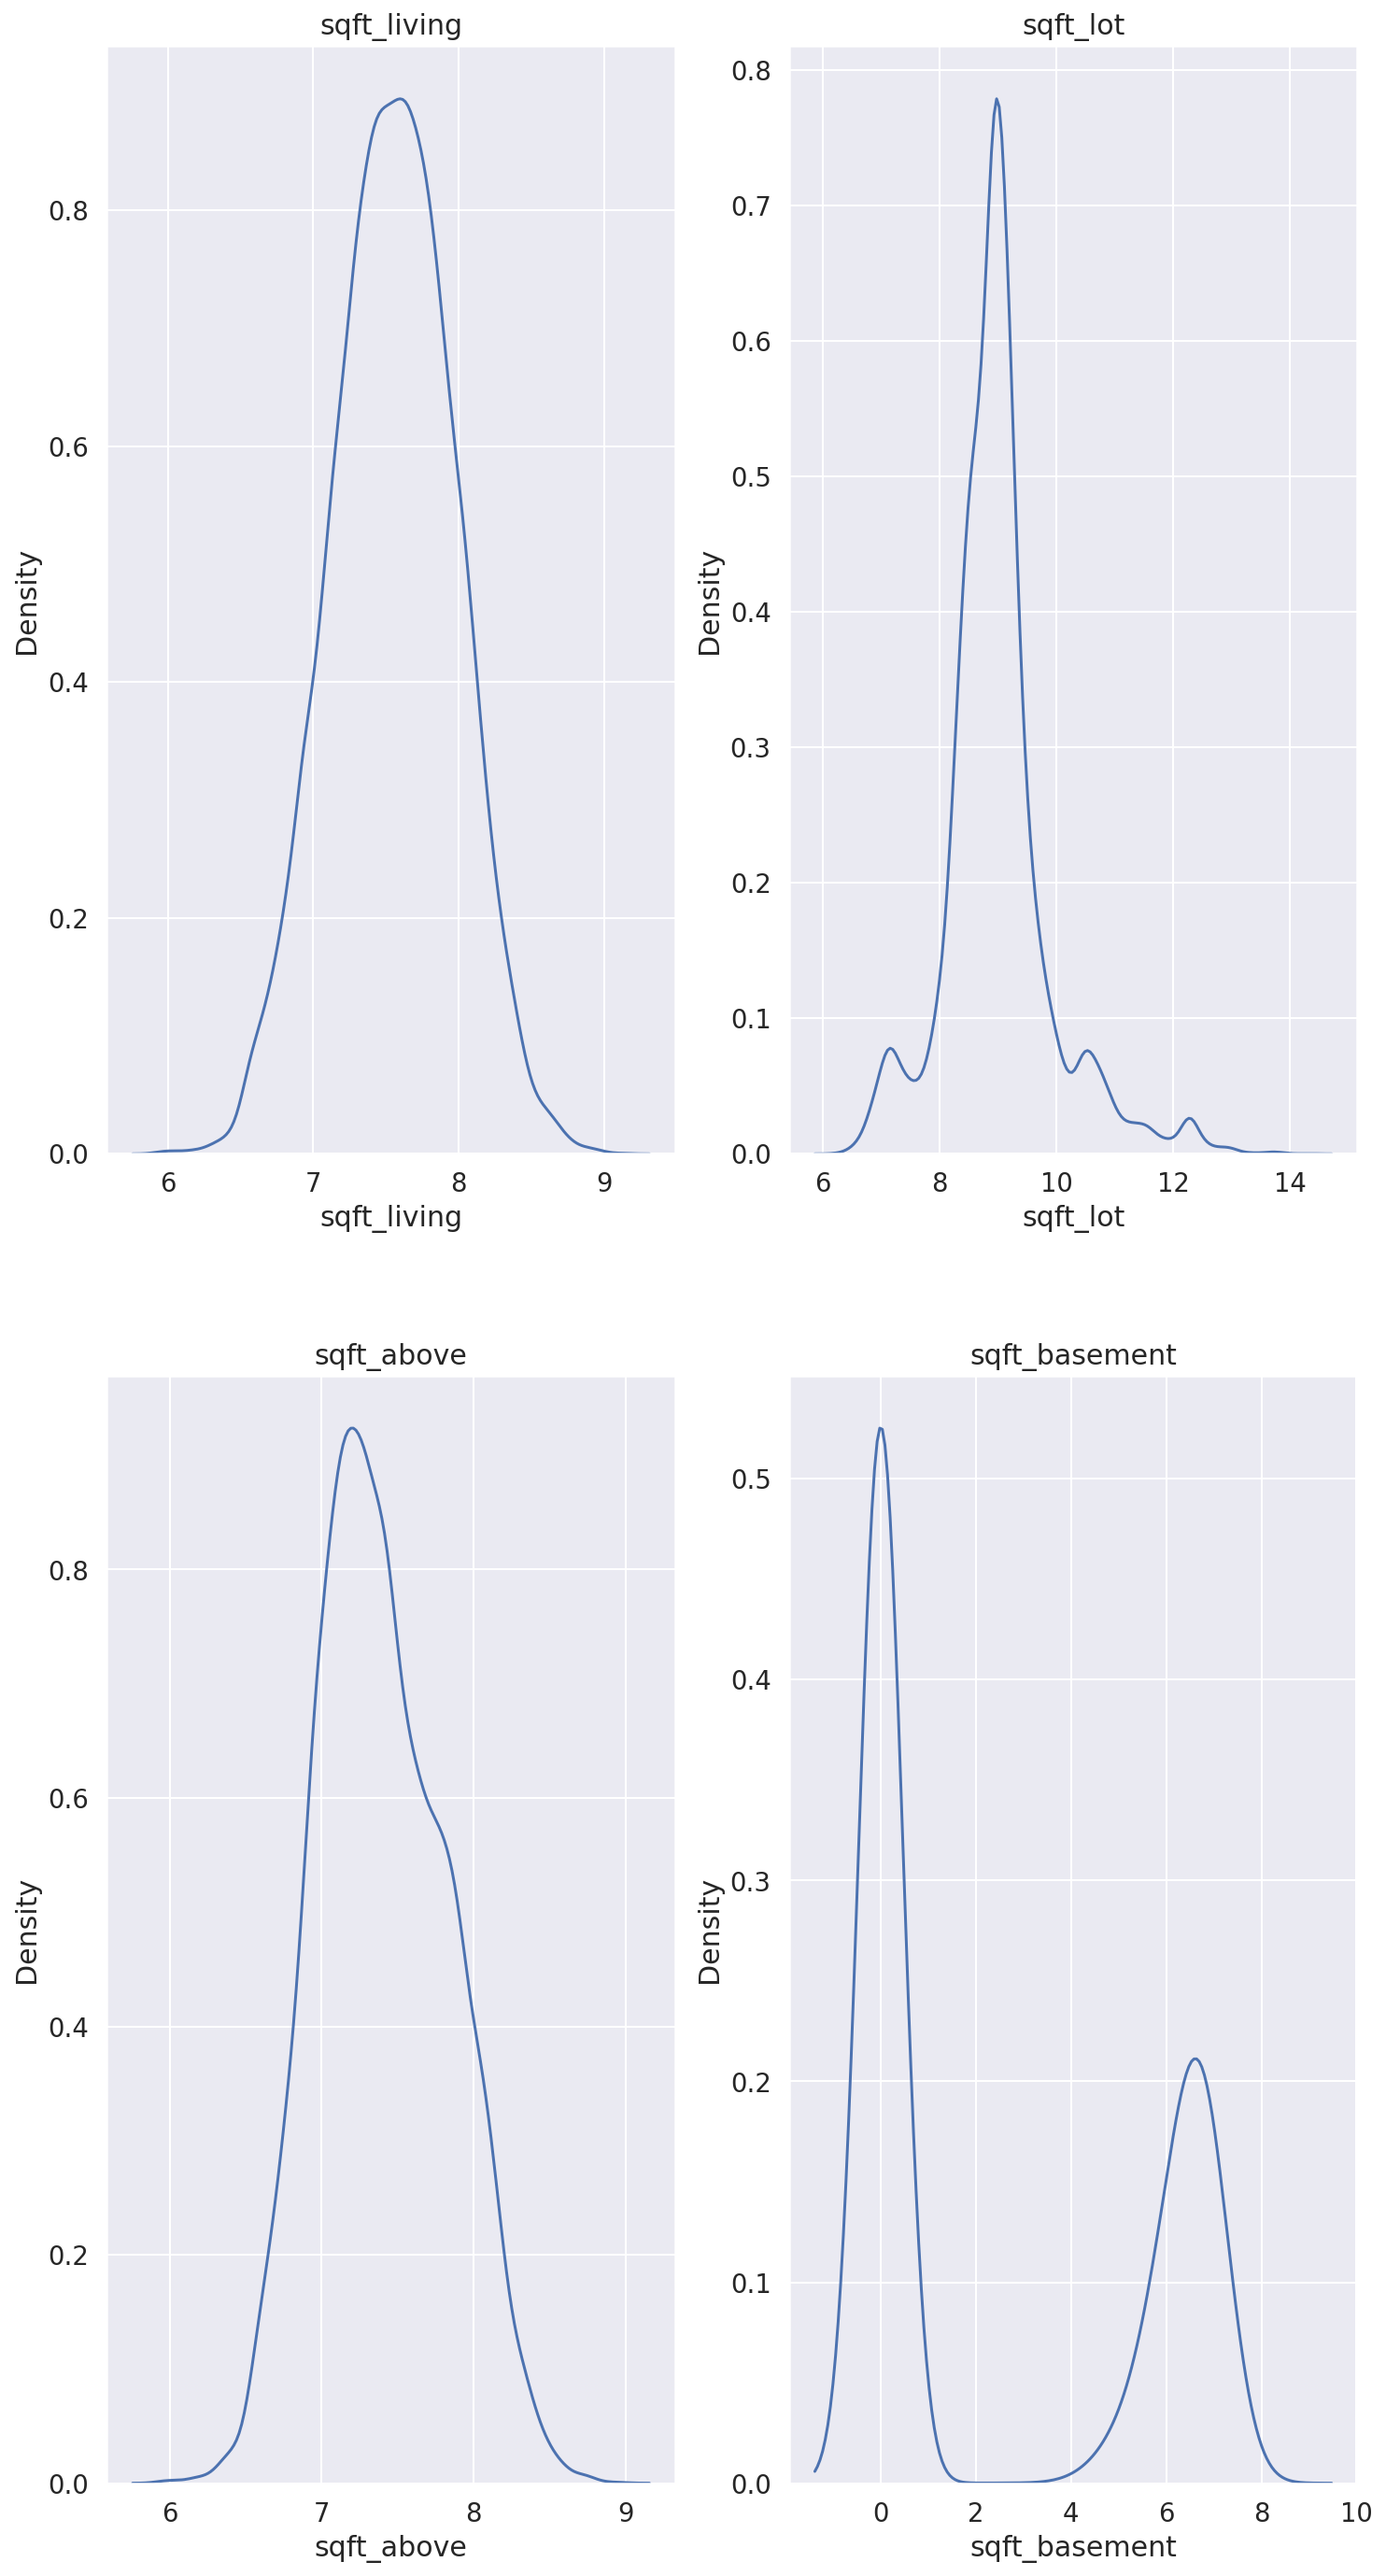

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 24))

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [26]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(opacity = 0.45)
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
fig

## 피쳐 엔지니어링

In [27]:
target = train['price']
train_id = train['id']
test_id = test['id']
del train['price']
del train['id']
del test['id']

In [28]:
for df in [train, test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['date'] = df['date'].astype('int')
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [29]:
train

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      20141013         3       1.00     7.074117  8.639588     1.0   
1      20150225         2       1.00     6.647688  9.210440     1.0   
2      20150218         3       2.00     7.427144  8.997271     1.0   
3      20140627         3       2.25     7.447751  8.827615     2.0   
4      20150115         3       1.50     6.966967  9.181118     1.0   
...         ...       ...        ...          ...       ...     ...   
15030  20141014         4       2.50     7.832411  8.703507     2.0   
15031  20150326         4       3.50     8.163656  8.881975     2.0   
15032  20140521         3       2.50     7.333676  7.031741     3.0   
15033  20150223         4       2.50     7.745436  8.668024     2.0   
15034  20141015         2       0.75     6.928538  6.981935     2.0   

       waterfront  view  condition  grade  ...      lat     long  \
0               0     0          3      7  ...  47.5112 -122.257   
1               0     0          3      6  ...  47.7379 -122.233   
2               0     0          3      8  ...  47.6168 -122.045   
3               0     0          3      7  ...  47.3097 -122.327   
4               0     0          3      7  ...  47.4095 -122.315   
...           ...   ...        ...    ...  ...      ...      ...   
15030           0     0          3      9  ...  47.5137 -122.167   
15031           0     0          3      9  ...  47.5537 -122.398   
15032           0     0          3      8  ...  47.6993 -122.346   
15033           0     0          3      8  ...  47.5107 -122.362   
15034           0     0          3      7  ...  47.5941 -122.299   

       sqft_living15  sqft_lot15  total_rooms  grade_condition  sqft_total  \
0               1340        5650         4.00               21   15.713705   
1               2720        8062         3.00               18   15.858129   
2               1800        7503         5.00               24   16.424415   
3               2238        6819         5.25               21   16.275366   
4               1650        9711         4.50               21   16.148085   
...              ...         ...          ...              ...         ...   
15030           2520        6023         6.50               27   16.535918   
15031           2050        6200         7.50               27   17.045631   
15032           1530        1509         5.50               24   14.365418   
15033           1830        7200         6.50               24   16.413460   
15034           1020        1357         2.75               21   13.910472   

       sqft_total_size  sqft_total15  is_renovated  
0            22.787821          6990             0  
1            22.505817         10782             0  
2            23.851559          9303             0  
3            23.723117          9057             0  
4            23.115052         11361             0  
...                ...           ...           ...  
15030        24.368329          8543             0  
15031        31.723826          8250             0  
15032        21.699094          3039             0  
15033        24.158895          9030             0  
15034        20.839010          2377             0  

[14897 rows x 25 columns]

## XGB, LGB, HGB의 grid search

In [30]:
param_grid_lgb = {
    'eta': [0.1, 0.01],
    'max_depth': [15, 20, 30],
    'n_estimators' : [100, 200, 500, 1000]
}

In [31]:
def rmse(test_target, pred):
    return np.sqrt(mean_squared_error(np.expm1(test_target), np.expm1(pred)))

In [32]:
def my_GridSearch(model, train, y, param_grid = param_grid_lgb, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid_lgb, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * score)
    results.sort_values('RMSLE', inplace = True)
    return results

In [33]:
random_state=2020

xgb = XGBRegressor(tree_method = 'hist', random_state=random_state)
lgb = LGBMRegressor(random_state=random_state)
hgb = HistGradientBoostingRegressor(random_state=random_state) 

In [ ]:
a = my_GridSearch(lgb, train, target, param_grid_lgb, verbose=2, n_jobs=5)
a

In [63]:
param_grid_hgb = {
    'learning_rate': [0.1, 0.01],
    'max_iter' : [100, 200, 500],
    'max_depth' : [10, 20, 30]
}

In [64]:
def my_GridSearch(model, train, y, param_grid = param_grid_hgb, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid_hgb, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    print(grid_model.get_params().keys())
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * score)
    results.sort_values('RMSLE', inplace = True)
    return results

In [65]:
b = my_GridSearch(hgb, train, target, param_grid_hgb, verbose=2, n_jobs=5)
b

dict_keys(['cv', 'error_score', 'estimator__categorical_features', 'estimator__early_stopping', 'estimator__l2_regularization', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_bins', 'estimator__max_depth', 'estimator__max_iter', 'estimator__max_leaf_nodes', 'estimator__min_samples_leaf', 'estimator__monotonic_cst', 'estimator__n_iter_no_change', 'estimator__random_state', 'estimator__scoring', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
Fitting 5 folds for each of 18 candidates, totalling 90 fits


learning_rate  max_depth  max_iter     RMSLE
5            0.10         20       500  0.160350
4            0.10         20       200  0.160360
8            0.10         30       500  0.160591
7            0.10         30       200  0.160601
1            0.10         10       200  0.160786
2            0.10         10       500  0.160786
3            0.10         20       100  0.161429
6            0.10         30       100  0.161500
0            0.10         10       100  0.161561
14           0.01         20       500  0.166197
17           0.01         30       500  0.166197
11           0.01         10       500  0.166553
13           0.01         20       200  0.202729
16           0.01         30       200  0.202729
10           0.01         10       200  0.202739
9            0.01         10       100  0.275752
12           0.01         20       100  0.275752
15           0.01         30       100  0.275752

In [93]:
param_grid_xgb = {
    'learning_rate': [0.1, 0.01],
    'max_iter' : [100, 200, 500],
    'max_depth' : [10, 20, 30]
}

In [94]:
def my_GridSearch(model, train, y, param_grid = param_grid_xgb, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid_xgb, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    print(grid_model.get_params().keys())
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * score)
    results.sort_values('RMSLE', inplace = True)
    return results

In [33]:
c = my_GridSearch(hgb, train, target, param_grid_xgb, verbose=2, n_jobs=5)
c

'sqft_basement'

In [96]:
print(xgb.get_params().keys())

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])


## Grid search로 얻은 최적의 파라미터로 모델 구동

In [36]:
hgb = HistGradientBoostingRegressor(max_depth = 20, max_iter = 200, learning_rate = 0.1, random_state=random_state)

In [37]:
xgb = XGBRegressor(tree_method = 'hist', learning_rate = 0.3, gamma = 0, subsample = 1, min_child_weight = 1,
                   max_depth = 5, colsample_bytree = 0.8, random_state=random_state)

In [38]:
lgb = LGBMRegressor(eta = 0.015, max_depth = -1, n_estimators = 200, num_leaves = 31, min_data_in_leaf = 30, 
                    objective = 'regression',random_state=random_state , min_child_samples= 20, boosting = 'gbdt',
                   feature_fraction = 0.9, bagging_freq = 1, bagging_fraction = 0.9, bagging_seed = 11, metric = 'rmse',
                   lambda_l1 = 0.1, verbosity = -1 )

In [39]:
xgb.fit(train, target)
lgb.fit(train, target)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.015 will be ignored. Current value: learning_rate=0.1


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', eta=0.015, feature_fraction=0.9, lambda_l1=0.1,
              metric='rmse', min_data_in_leaf=30, n_estimators=200,
              objective='regression', random_state=2020, verbosity=-1)

In [40]:
hgb_pred = np.expm1(xgb.predict(test))
lgb_pred = np.expm1(lgb.predict(test))
ensemble = 0.7*lgb_pred + 0.3*hgb_pred

In [41]:
submission1 = pd.DataFrame({'id': test_id, 'price': ensemble})
submission1.to_csv('ensemble.csv', index=False)

In [51]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    scores = cross_validate(model, train, target,
                  return_train_score = True, n_jobs = -1)
    print(np.mean(scores['train_score']), np.mean(scores['test_score']))
    
    data_dir = os.getenv('HOME')+'/aiffel/AIFFEL'

    submission_path = join(data_dir, 'submission.csv')
    submission = pd.read_csv(submission_path)

    submission['price'] = prediction

    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
    submission.to_csv(submission_csv_path, index=False)

In [52]:
save_submission(hgb, train, target, test, 'lgbm', rmsle='0.0168')

0.94144874423027 0.9019952181242414


## 캐글 대회 우수 노드의 모델 및 하이퍼 파라미터 적용

Text(0, 0.5, 'score')

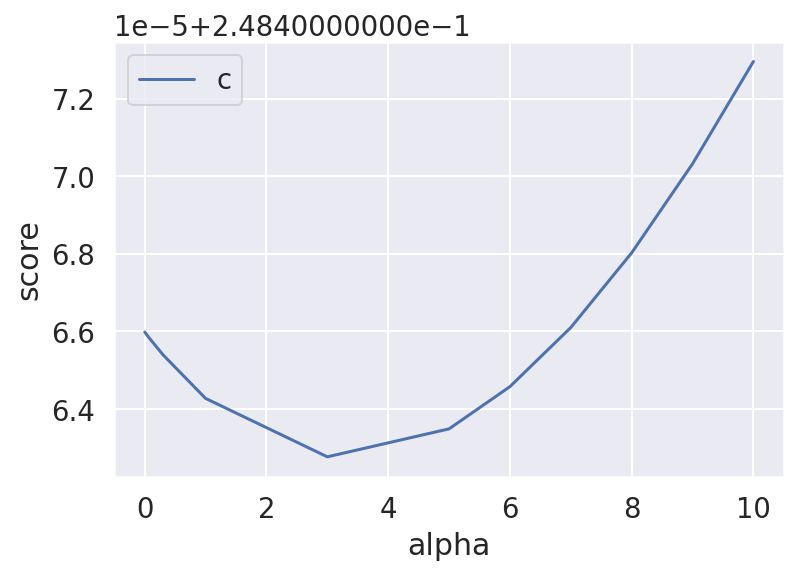

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV


kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(train, target)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5,6,7,8,9,10]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)
    
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

In [58]:
alphas_alt = [5.8,5.9,6,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(train, target)

print("Ridge rmse : ",cv_rmse(ridge_model2).mean())

Ridge rmse :  0.24846432396689905


In [59]:
print("Best of alpha in ridge model :" ,ridge_model2.steps[1][1].alpha_)

Best of alpha in ridge model : 5.8


[Text(0.5, 0, 'Penalized Regression Coefficients')]

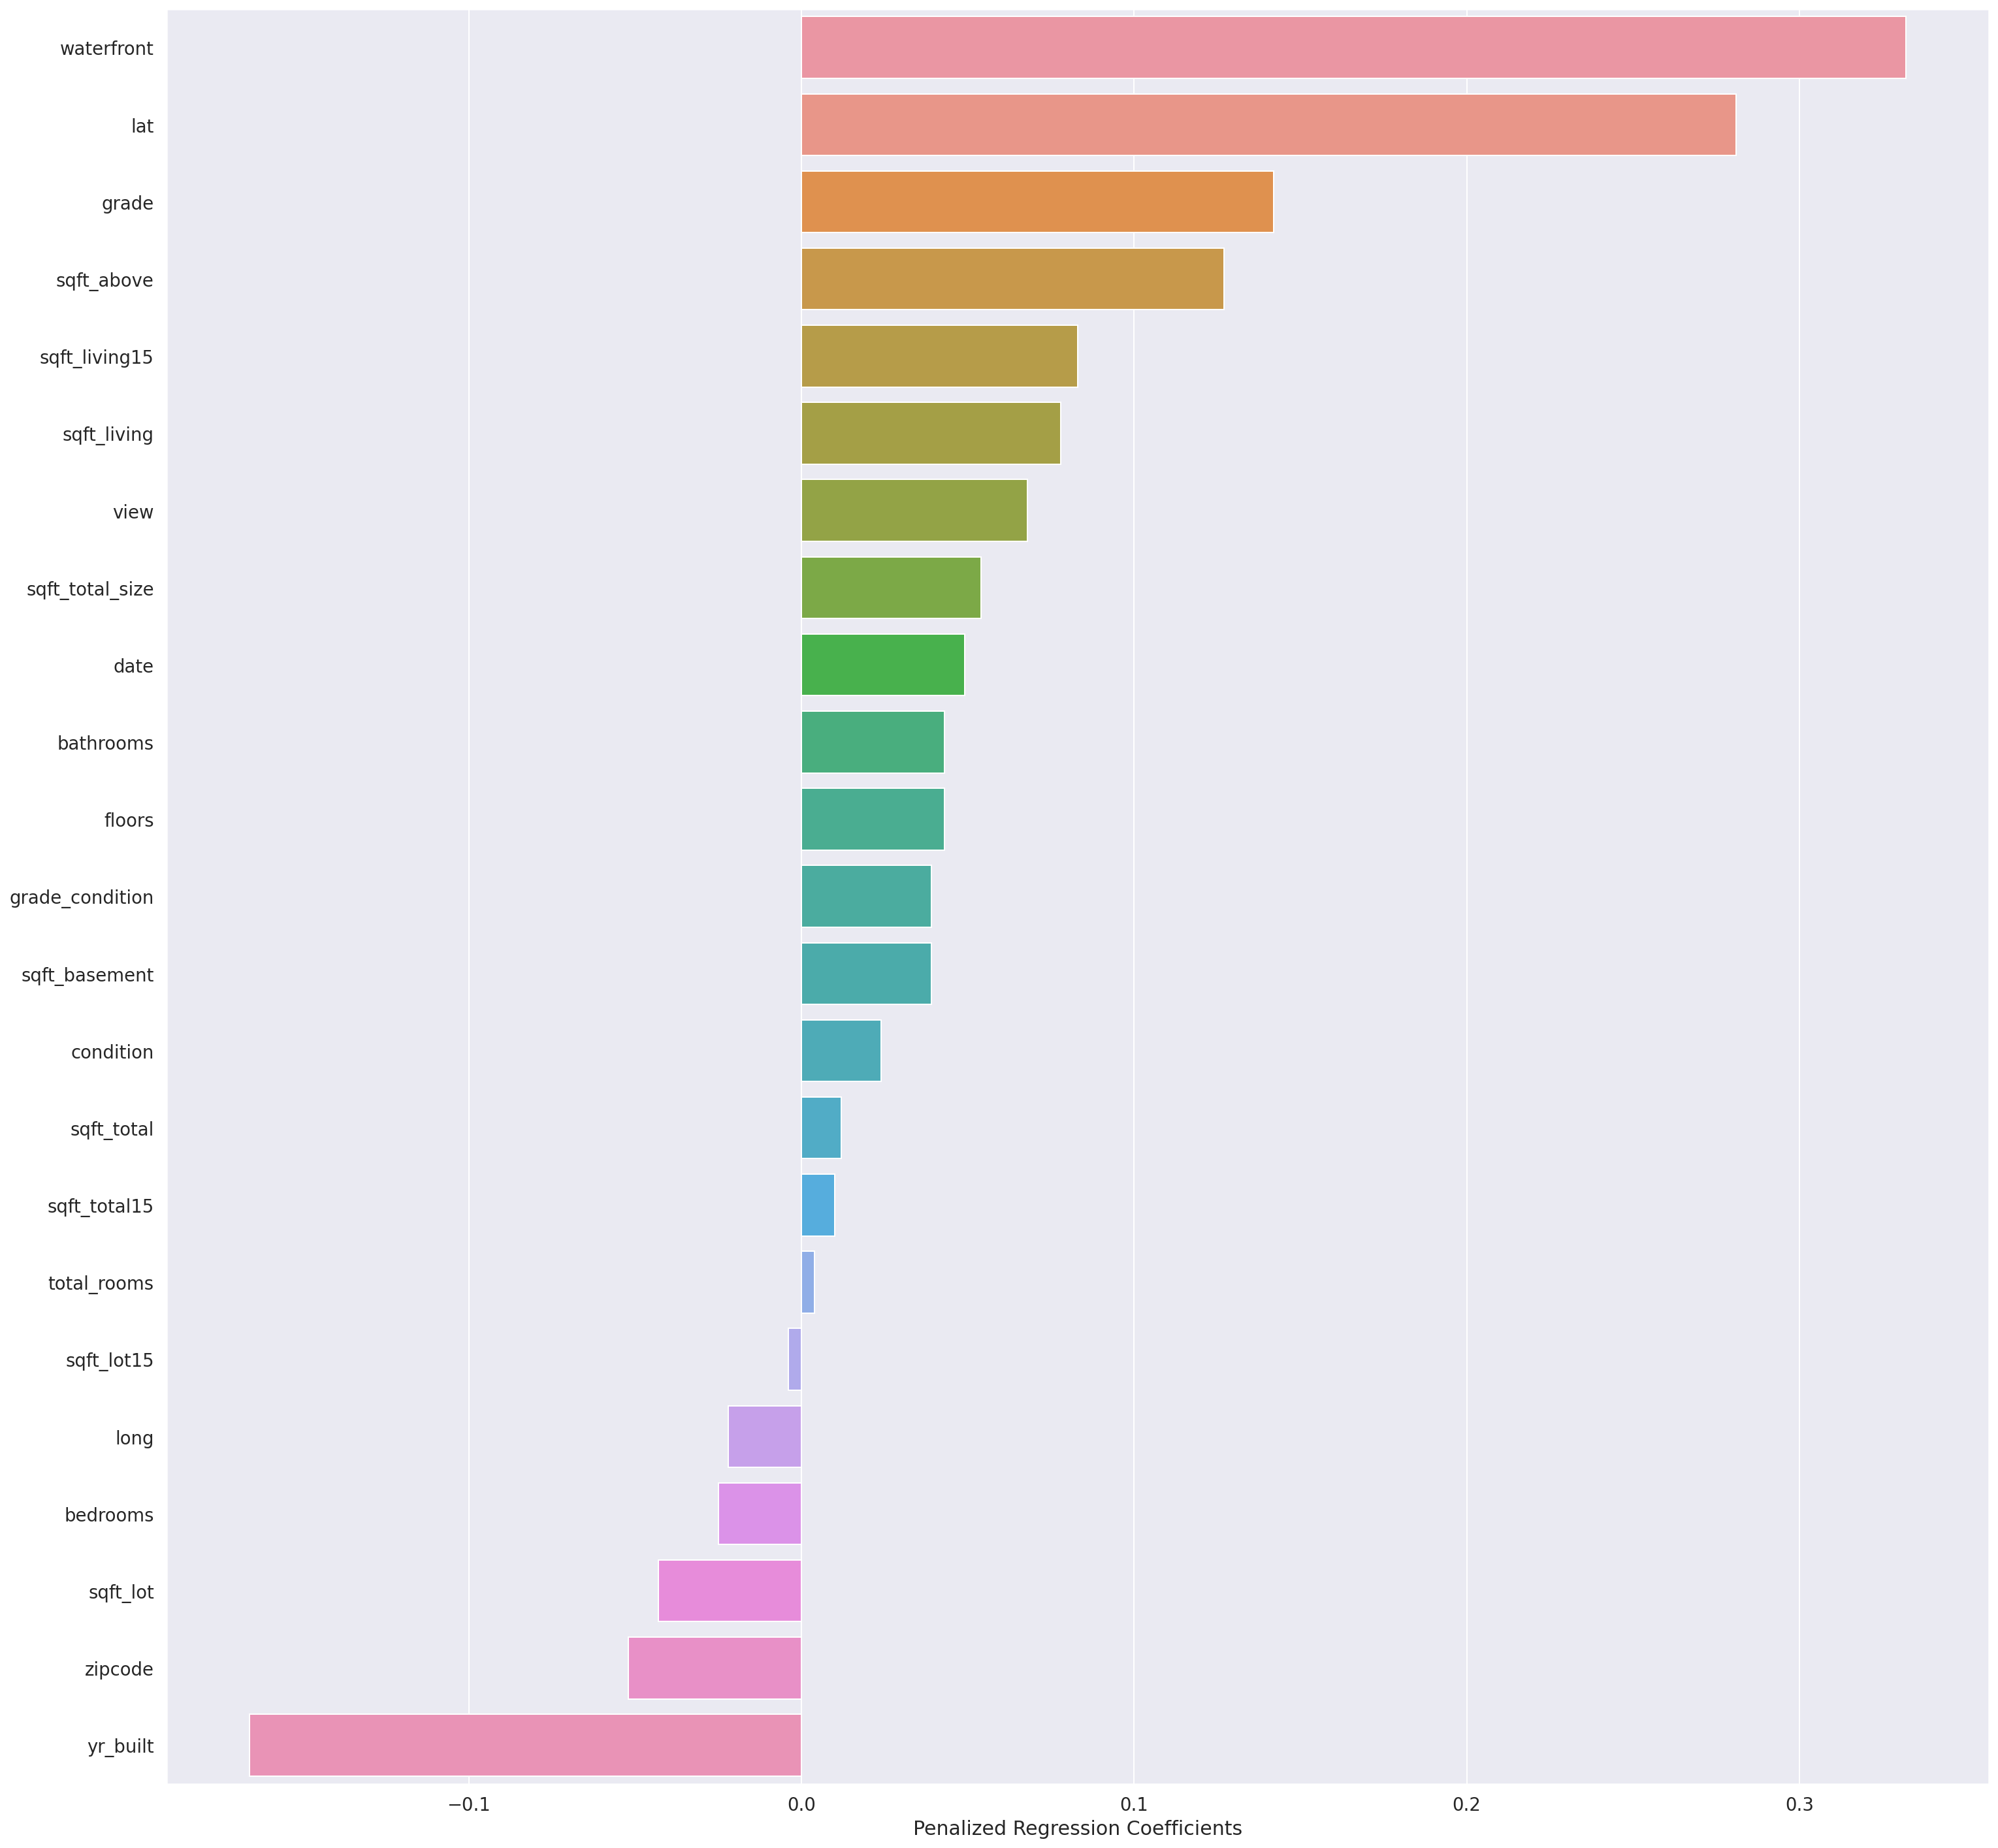

In [61]:
ridge_coef = pd.DataFrame(np.round_(ridge_model2.steps[1][1].coef_, decimals=3), 
test.columns, columns = ["penalized_regression_coefficients"])
# remove the non-zero coefficients
ridge_coef = ridge_coef[ridge_coef['penalized_regression_coefficients'] != 0]
# sort the values from high to low
ridge_coef = ridge_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# plot the sorted dataframe
fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= ridge_coef.index , 
data=ridge_coef)
ax.set(xlabel='Penalized Regression Coefficients')

In [63]:
train_columns = [c for c in train.columns if c not in ['id']]

In [66]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, target))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139561	valid_1's rmse: 0.163768
[1000]	training's rmse: 0.12165	valid_1's rmse: 0.160135
[1500]	training's rmse: 0.109382	valid_1's rmse: 0.159611
Early stopping, best iteration is:
[1766]	training's rmse: 0.103865	valid_1's rmse: 0.159308
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139847	valid_1's rmse: 0.162683
[1000]	training's rmse: 0.121839	valid_1's rmse: 0.159427
[1500]	training's rmse: 0.10959	valid_1's rmse: 0.15846
[2000]	training's rmse: 0.0997916	valid_1's rmse: 0.158173
Early stopping, best iteration is:
[2067]	training's rmse: 0.0986222	valid_1's rmse: 0.158156
[LightGBM] [Warning] min_data_in_leaf is se

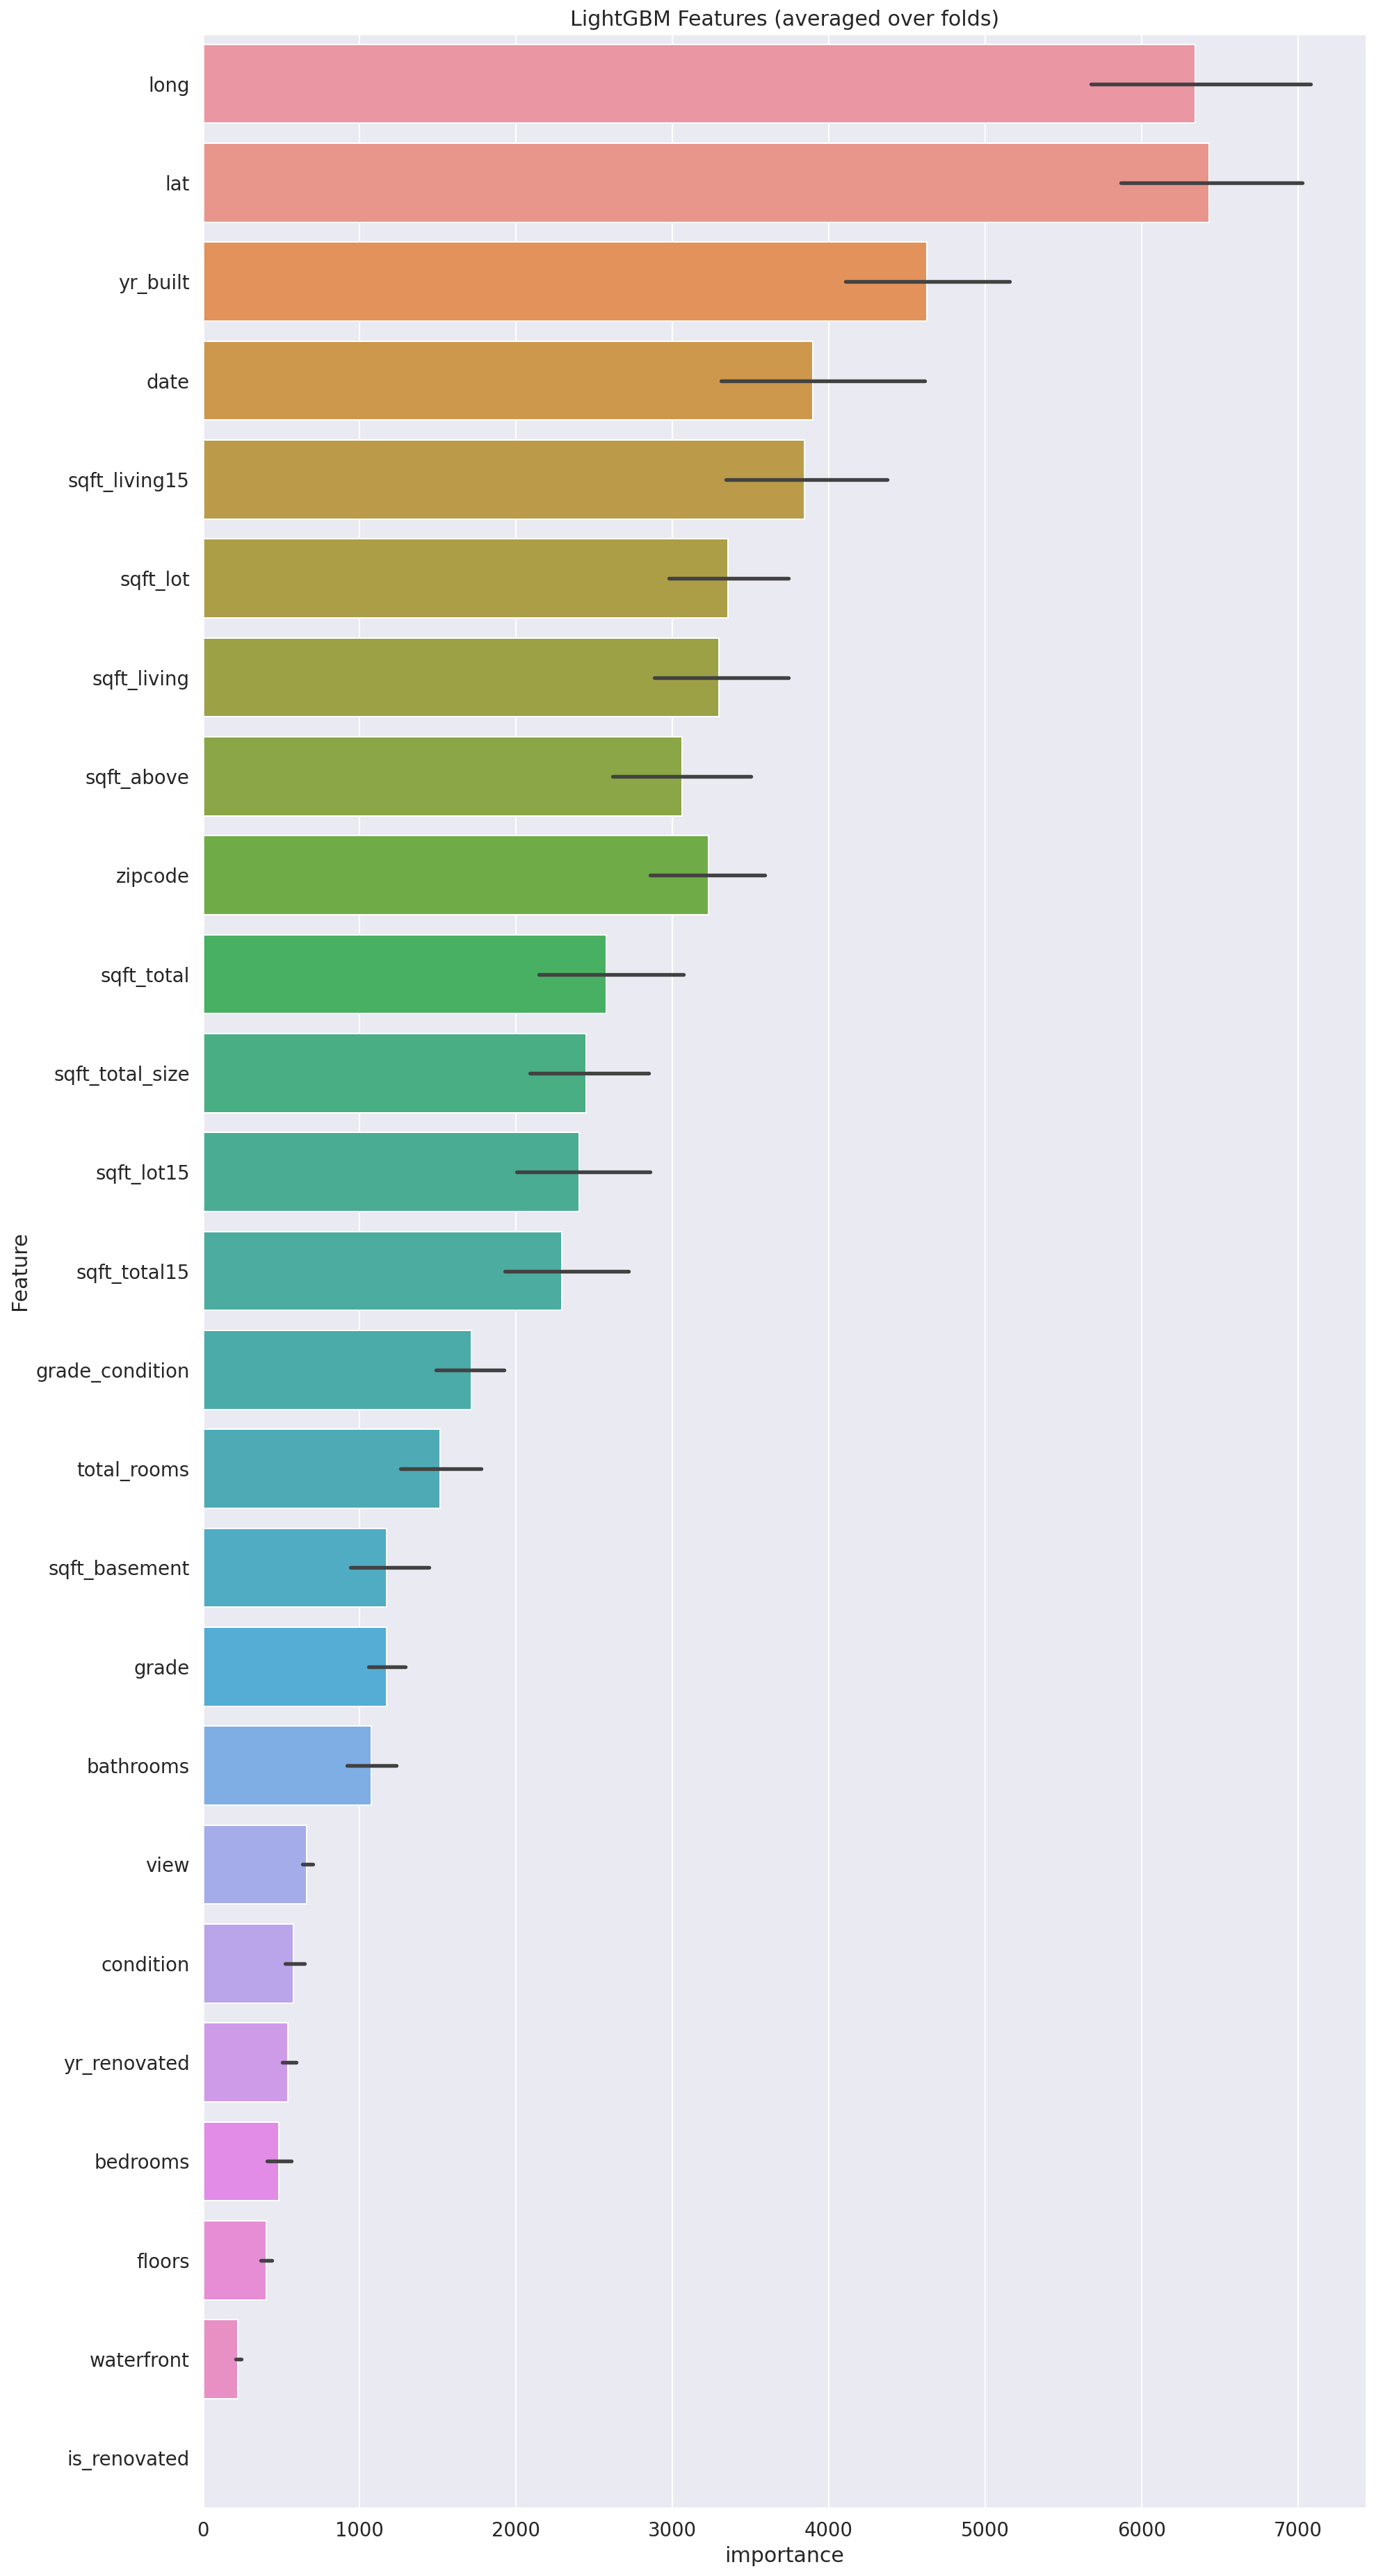

In [67]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [69]:
test_ridge_preds = np.expm1(ridge_model2.predict(test))
test_lgb_preds = np.expm1(predictions)
test_ensemble_preds = 0.7*test_lgb_preds + 0.3*test_ridge_preds
submission0 = pd.DataFrame({'id': test_id, 'price': test_ridge_preds})
submission0.to_csv('ridge.csv', index=False)
submission = pd.DataFrame({'id': test_id, 'price': test_lgb_preds})
submission.to_csv('lightgbm.csv', index=False)
submission1 = pd.DataFrame({'id': test_id, 'price': test_ensemble_preds})
submission1.to_csv('WeightAvg1.csv', index=False)

# 회고

캐글 대회의 프로젝트 주제인 house price prediction EDA를 해보았다. 직접 EDA를 수행하면서 결측치제거, 이상치제거, 유의미한 feature들을 엔지니어링해보는 실습을 해보았다. 

많은 부분을 https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook#4.-%EB%AA%A8%EB%8D%B8%EB%A7%81 의 코드를 참조하였으며,
평가받은 score는 아래와 같다

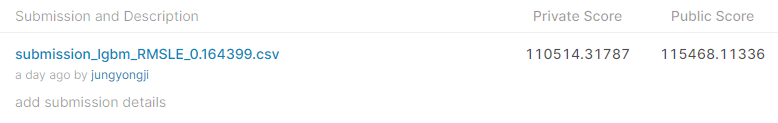

11만점에 준하는 스코어는 얻었지만, 결국 11만점 이하의 결과를 얻지 못했다. 
그 이유는 다음과 같이 추론해 볼 수 있는데, 마지막으로 private score 8.8만점을 받은 위 링크의 코드에 나온 대로 하이퍼 파라미터와 해당 모델을 적용하여 스코어를 계산해보았을 때, 11만점은 커녕 13만점으로 치솟았다. 물론 EDA 방법과 모델의 하이퍼 파라미터가 동일한 방법으로 진행되지 않아서 높게 나온 것일수도 있지만, 나의 의견으로는 EDA, 즉, preprocessing 방법이 잘못되어서 좋은 모델로 좋은 하이퍼 파라미터를 그대로 따라해도 결과가 안좋게 나온 것이라고 결론을 지었다.

결과적으로 역시나 모델 선정, 하이퍼 파라미터 선정, 그리고 앙상블로 얻은 효과보다 EDA로 얻는 효과가 지대하다는 것을 깨달았다.